In [1]:
#-------- Import Libraries --------#
import torch
import os
import time
import sys
import random
import pickle
import mlflow
import collections
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
#-------- Import Modules from project--------#
import encoding as enc
from model import Net, Net_thesis, Net_project, Net_project_simple_CNN_RNN, Net_project_transformer_CNN_RNN
import functions as func

In [3]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [4]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [5]:
#-------- Directories --------#

DATADIR = '/data/'
TRAINDIR = '../data/train'
VALIDATIONDIR = '../data/validation'
MATRICES = '/data/Matrices'


In [6]:
#-------- Unzip Train --------#

try:
    if len(os.listdir(TRAINDIR)) != 0:
        print("{} already unzipped.".format(TRAINDIR))
except:
    !unzip ../data/train.zip -d ../data/train

    
#-------- Unzip Validation --------#

try:
    if len(os.listdir(VALIDATIONDIR)) != 0:
        print("{} already unzipped.".format(VALIDATIONDIR))
except:
    !unzip ../data/validation.zip -d ../data/validation
    
print('Train directory:\n\n', '\n'.join(str(p) for p in os.listdir(TRAINDIR)), '\n\n')
print('Validation directory:\n\n','\n'.join(str(p) for p in os.listdir(VALIDATIONDIR)))

../data/train already unzipped.
../data/validation already unzipped.
Train directory:

 P2_labels.npz
P3_input.npz
P4_input.npz
P2_input.npz
__MACOSX
P1_input.npz
P3_labels.npz
P4_labels.npz
P1_labels.npz 


Validation directory:

 P5_input.npz
P5_labels.npz
__MACOSX


In [7]:
#-------- Import Dataset --------#

data_list = []
target_list = []

import glob
for fp in glob.glob("../data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
for fp in glob.glob("../data/validation/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
data_partitions = len(data_list)

print("Number of files:", data_partitions)

for i in range(data_partitions):
    print("Size of file", i, len(data_list[i]))

Number of files: 5
Size of file 0 1480
Size of file 1 1532
Size of file 2 1168
Size of file 3 1526
Size of file 4 1207


In [8]:
for i in range(len(target_list)):
    print("File:", i)
    frequency = collections.Counter(target_list[i])
    print(dict(frequency), "\n")

File: 0
{1.0: 370, 0.0: 1110} 

File: 1
{1.0: 383, 0.0: 1149} 

File: 2
{1.0: 292, 0.0: 876} 

File: 3
{1.0: 380, 0.0: 1146} 

File: 4
{1.0: 301, 0.0: 906} 



In [9]:
cross_validation = False
merge = False

In [10]:
#-------- Hyperparameters to fine tune -------#
embedding = "baseline" #baseline
numHN=64
numFilter=100
dropOutRate=0.1
keep_energy=True

In [11]:
print(len(data_list), "\n")

for i in range(len(data_list)):
    print("File", i)
    seq = func.extract_sequences(data_list[i])

    seq['PEP_len'] = seq['peptide'].str.len()
    seq['TCR_len'] = seq['TCR'].str.len()
    seq['MHC_len'] = seq['MHC'].str.len()

    print("MHC:", list(set(seq['MHC'].tolist())))
    leng_TCR = list()
    leng_MHC = list()
    leng_PEP = list()

    for i in range(len(seq)):

        if seq['PEP_len'][i] not in leng_PEP:
            leng_PEP.append(seq['PEP_len'][i])

        if seq['MHC_len'][i] not in leng_MHC:
            leng_MHC.append(seq['MHC_len'][i]) 

        if seq['TCR_len'][i] not in leng_TCR:
            leng_TCR.append(seq['TCR_len'][i])

    print("MHC length range:", sorted(leng_MHC))
    print("PEP length range:",sorted(leng_PEP))
    print("TCR length range:",sorted(leng_TCR))
    print("\n")

5 

File 0
MHC: ['GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETL']
MHC length range: [179]
PEP length range: [9]
TCR length range: [200, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 228]


File 1
MHC: ['GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETL']
MHC length range: [179]
PEP length range: [9]
TCR length range: [201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227]


File 2
MHC: ['GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETL']
MHC lengt

In [12]:
#data_list_aa = list()

#for i in range(5):
#    data_list_aa.append(func.extract_aa_and_energy_terms(data_list[i]))

In [13]:
# Structure of 1 complex:
#pd.DataFrame(data_list_aa[0][0])

In [14]:
#embedding of data
data_list_enc_mhc = list()
data_list_enc_pep = list() 
data_list_enc_tcr = list()
start = time.time()
mhc_bool = False

#create directory to fetch/store embedded
embedding_dir= '../data/embeddedFiles/'

if embedding == "baseline":
        print('baseline')
        data_list_enc = data_list
        
elif embedding == "esm-1b":   
    
    try:
        os.mkdir(embedding_dir)
        data_list_enc = []
    
        print("esm-1b")
        count = 0
        
        for dataset in data_list:
            
            mhc_enc = list()
            pep_enc = list()
            tcr_enc = list()
            
            print("\nWorking on file", count)
            count += 1
            x_enc = func.extract_sequences(dataset, merge=merge)
            print("Sequences are extracted")
            
            if merge:
                print("Merge true")
                #print(x_enc['all'].tolist())
                x_enc = enc.esm_1b(x_enc['all'].tolist(), pooling=False)
                x_enc = np.array(x_enc[0])
                print(x_enc.shape)
                data_list_enc.append(x_enc)
                #save
                outfile = open(embedding_dir + 'dataset-all-{}-file{}-500'.format(embedding, count),'wb')
                pickle.dump(data_list_enc, outfile)
                outfile.close()
                
            else:
                print("Merge false")
                print(len(x_enc['MHC'].tolist()), len(x_enc['peptide'].tolist()), len(x_enc['TCR'].tolist()))
                
                if mhc_bool == False:
                    mhc_enc_1 = enc.esm_1b_peptide(x_enc['MHC'].tolist()[i], pooling=False)
                    mhc_bool == True
                    
                for i in range(len(x_enc['MHC'].tolist())):
                    if i % 5 == 0:
                        print("\nFlag", i, " - Time:", round(time.time()-start,2))
                    mhc_enc.append(mhc_enc_1)
                    pep_enc.append(enc.esm_1b_peptide(x_enc['peptide'].tolist()[i], pooling=False))
                    tcr_enc.append(enc.esm_1b_peptide(x_enc['TCR'].tolist()[i], pooling=False))
                
                mhc_enc = [x.tolist() for x in mhc_enc]
                pep_enc = [x.tolist() for x in pep_enc]
                tcr_enc = [x.tolist() for x in tcr_enc]
                
                #print("results are stacking")
                #x_enc = np.vstack((mhc_enc[0],pep_enc[0],tcr_enc[0]))
                #print("before extending:", x_enc.shape)
                
                # x_enc should be enc + energy terms
                data_list_enc_mhc.append(mhc_enc) 
                data_list_enc_pep.append(pep_enc) 
                data_list_enc_tcr.append(tcr_enc) 
                print("ESM_1B is done\n")

                #save
                outfilemhc = open(embedding_dir + 'dataset-{}-file{}-mhc'.format(embedding, count),'wb')
                outfilepep = open(embedding_dir + 'dataset-{}-file{}-pep'.format(embedding, count),'wb')
                outfiletcr = open(embedding_dir + 'dataset-{}-file{}-tcr'.format(embedding, count),'wb')
                pickle.dump(mhc_enc, outfilemhc)
                pickle.dump(pep_enc, outfilepep)
                pickle.dump(tcr_enc, outfiletcr)
                outfilemhc.close()
                outfilepep.close()
                outfiletcr.close()
                

        if embedding == "esm_ASM":
            for dataset in data_list:
                x_enc = func.extract_sequences(dataset, merge=merge).values.tolist()
                print(data_list_enc)
                x_enc = [enc.esm_ASM(seq, pooling=False) for seq in x_enc]
                data_list_enc.append(x_enc)

            #save
            outfile = open(embedding_dir + 'dataset-{}-file{}'.format(embedding, count),'wb')
            pickle.dump(data_list_enc, outfile)
            outfile.close()

        else:         
            for dataset in data_list:
                x_enc = func.extract_sequences(dataset, merge=merge).values.tolist()
                print(data_list_enc)
                x_enc = [enc.encodePeptidesCNN(seq, scheme=embedding) for seq in x_enc]
                data_list_enc.append(x_enc)
            print(data_list_enc)

            #save
            outfile = open(embedding_dir + 'dataset-{}-file{}'.format(embedding, count),'wb')
            pickle.dump(data_list_enc, outfile)
            outfile.close()

    except:
        for dataset in data_list:
            count = -1
            count += 1
            if merge:
                with open(embedding_dir+'dataset-all-{}'.format(embedding)) as f:
                    data_list_enc =  pickle.load(f)
            else:
                with open(embedding_dir + 'dataset-{}-file{}-mhc'.format(embedding, count)) as f:
                    data_list_enc_mhc.append(pickle.load(f))
                with open(embedding_dir + 'dataset-{}-file{}-pep'.format(embedding, count)) as f:
                    data_list_enc_pep.append(pickle.load(f))
                with open(embedding_dir + 'dataset-{}-file{}-tcr'.format(embedding, count)) as f:
                    data_list_enc_tcr.append(pickle.load(f))


baseline


In [15]:
if embedding == "esm-1b":
    pd.DataFrame(data_list_enc_tcr[0][0])

In [16]:
if embedding == "esm-1b":
    data_list_enc = list()
    for t in range(len(data_list)):
        print(t)
        data_list_t = list()
        for cmplx in range(len(data_list[t])):

            df = pd.DataFrame( data_list[t][cmplx] )
            new_df = pd.DataFrame( func.extract_aa_and_energy_terms(data_list[t])[cmplx] )

            df_emb_mhc = pd.DataFrame(data_list_enc_mhc[t][cmplx])
            df_emb_pep = pd.DataFrame(data_list_enc_pep[t][cmplx])
            df_emb_tcr = pd.DataFrame(data_list_enc_tcr[t][cmplx])

            df_emb_mhc['aa'] = '-'
            df_emb_pep['aa'] = '-'    
            df_emb_tcr['aa'] = '-'

            for mhc in range(len(df_emb_mhc)):
                df_emb_mhc['aa'][mhc] = func.return_aa(list(df.iloc[i,0:20]))

            for pep in range(len(df_emb_pep)):
                df_emb_pep['aa'][pep] = func.return_aa(list(df.iloc[179+i,0:20]))

            pad_index_list = sorted(new_df[new_df.iloc[:,34]=='X'].index.tolist())

            padding1_len = 0
            for pad in range(len(pad_index_list)):
                padding1_len += 1
                if pad_index_list[pad+1]-pad_index_list[pad] > 100:
                    tcr_start = pad_index_list[pad] + 1
                    tcr_end = pad_index_list[pad+1]
                    break
            padding2_len = len(pad_index_list) - padding1_len

            for tcr in range(len(df_emb_tcr)):
                df_emb_tcr['aa'][tcr] = func.return_aa(list(df.iloc[tcr_start+tcr, 0:20]))

            mhc = pd.concat([df_emb_mhc.reset_index(drop=True), df.iloc[:179,20:].reset_index(drop=True)], axis=1).iloc[:, :-1].reset_index(drop=True)
            pep = pd.concat([df_emb_pep.reset_index(drop=True), df.iloc[179:188,20:].reset_index(drop=True)], axis=1).iloc[:, :-1].reset_index(drop=True)
            padding1 = pd.DataFrame(0, index=np.arange(padding1_len), columns=pep.columns)
            tcr = pd.concat([df_emb_tcr.reset_index(drop=True), (df.iloc[tcr_start:tcr_end,20:]).reset_index(drop=True)], axis=1).iloc[:, :-1].reset_index(drop=True)
            padding2 = pd.DataFrame(0, index=np.arange(padding2_len), columns=pep.columns)

            final_cmplx = pd.concat([mhc,pep,padding1,tcr,padding2]).reset_index(drop=True)
            final_cmplx.columns = np.arange(len(final_cmplx.columns))
            data_list_t.append(np.array(final_cmplx))

        data_list_enc.append(np.array(data_list_t))

Dayana = False
if Dayana==True:
    if embedding == "esm-1b":
        data_list_enc = list()
        for t in range(len(data_list)):
            print(t)
            data_list_t = list()
            for cmplx in range(len(data_list[t])):

                df = pd.DataFrame( data_list[t][cmplx] )
                new_df = pd.DataFrame( func.extract_aa_and_energy_terms(data_list[t])[cmplx] ) ## I wrote this func, i can send you

                padding1_len = 0
                for pad in range(len(pad_index_list)):
                    padding1_len += 1
                    if pad_index_list[pad+1]-pad_index_list[pad] > 100:
                        tcr_start = pad_index_list[pad] + 1
                        tcr_end = pad_index_list[pad+1]
                        break
                padding2_len = len(pad_index_list) - padding1_len


                #mhc = pd.concat([df.iloc[:179,20:].reset_index(drop=True), ///here put mhc part of your embedding -> 0:179/// ], axis=1).iloc[:, :-1].reset_index(drop=True)
                #pep = pd.concat([df.iloc[179:188,20:].reset_index(drop=True), ///peptide part of your embedding -> 179:179+9/// ], axis=1).iloc[:, :-1].reset_index(drop=True)
                #tcr = pd.concat([(df.iloc[tcr_start:tcr_end,20:]).reset_index(drop=True), ///tcr partofyourembedding -> tcrstart: tcrend/// ], axis=1).iloc[:, :-1].reset_index(drop=True)
                #padding = pd.DataFrame(0, index=np.arange(padding1_len + padding2_len), columns=pep.columns)

                final_cmplx = pd.concat([mhc,pep,tcr,padding]).reset_index(drop=True)
                final_cmplx.columns = np.arange(len(final_cmplx.columns))
                data_list_t.append(np.array(final_cmplx))

            data_list_enc.append(np.array(data_list_t))


In [17]:
if embedding == "esm-1b":
    print(final_cmplx.to_markdown()) 

In [18]:
if embedding == "baseline":
    print("baseline")
    print(len(data_list_enc), "\n")

    for i in range(len(data_list)):
        print("number of complexes:", len(data_list[i]))
        print("number of rows:", len(data_list[i][0]))
        print("number of columns:", len(data_list[i][0][0]))
        print("\n")

else:
    print("ESM 1B:")
    final_cmplx

    print(len(data_list_enc), "\n")

    for i in range(len(data_list_enc)):
        print("number of complexes:", len(data_list_enc[i]))
        print("number of rows:", len(data_list_enc[i][0]))
        print("number of columns:", len(data_list_enc[i][0][0]))
        print("\n")
    


baseline
5 

number of complexes: 1480
number of rows: 420
number of columns: 54


number of complexes: 1532
number of rows: 420
number of columns: 54


number of complexes: 1168
number of rows: 420
number of columns: 54


number of complexes: 1526
number of rows: 420
number of columns: 54


number of complexes: 1207
number of rows: 420
number of columns: 54




In [30]:
#fixed hyperparameters
num_classes = 1
learning_rate = 0.001
bat_size = 128
epochs = 10
criterion = nn.BCEWithLogitsLoss()
early_stop = 5
print(early_stop)

5


In [31]:
X_train = np.concatenate(data_list_enc[0:3])
y_train = np.concatenate(target_list[0:3])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_valid = np.concatenate(data_list_enc[3:4])
y_valid = np.concatenate(target_list[3:4])
nsamples, nx, ny = X_valid.shape
print("Validation set shape:", nsamples,nx,ny)


X_test = np.concatenate(data_list_enc[3:4])
y_test = np.concatenate(target_list[3:4])
nsamples, nx, ny = X_test.shape
print("Test set shape:", nsamples,nx,ny)

# features and residues
features = list(range(ny))
residues = list(range(nx)) 
n_features = len(features)
input_size = len(residues)

# Dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
val_ds = []
for i in range(len(X_valid)):
    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i][:,features]), y_test[i]])
    
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds,batch_size=len(test_ds), shuffle=True)


Training set shape: 4180 420 54
Validation set shape: 1526 420 54
Test set shape: 1526 420 54


In [28]:
for batch_idx, (data, target) in enumerate(test_ldr):
    print(data.shape)

torch.Size([1526, 54, 420])


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
test loss: tensor(0.3756)


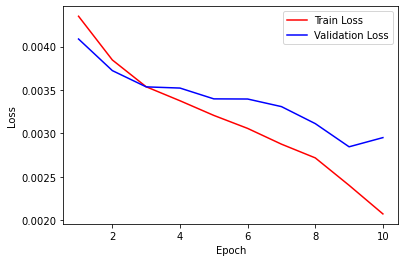

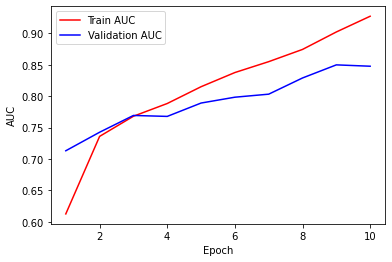

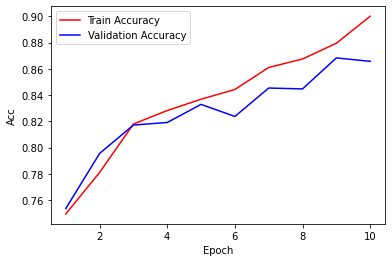

      target  pred
0          0     0
1          0     0
2          0     0
3          1     1
4          0     0
...      ...   ...
1521       0     0
1522       0     0
1523       0     0
1524       0     0
1525       0     0

[1526 rows x 2 columns]
AUC:  0.7812735372462571
MCC:  0.6192457068010306


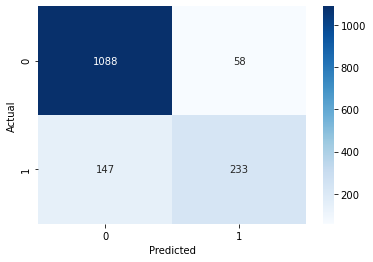

AUC: 0.781
205


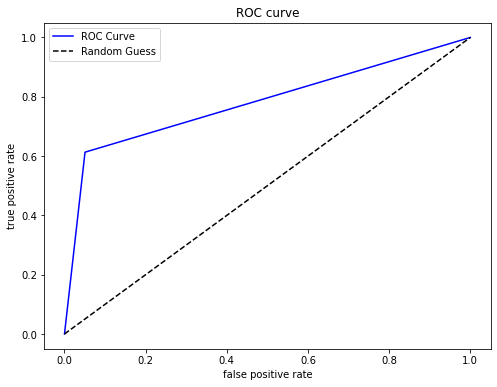

AUC:  0.7812735372462571
MCC:  0.6192457068010306
early stop: 5


In [32]:
###############################
###    CNN+RNN (thesis)     ###
###############################

if cross_validation == False:

    # Initialize network
    net = Net_project_simple_CNN_RNN(num_classes=num_classes, 
             n_features=n_features, 
             numHN=numHN, 
             numFilter=numFilter,
             dropOutRate=dropOutRate).to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=0.0005,
                           amsgrad=True,)
    
    train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs, test_preds, test_targs, test_loss = func.train_project(net, optimizer, train_ldr, val_ldr, test_ldr, X_valid, epochs, criterion, early_stop)
    print("test loss:", test_loss)

    #-------- Performance --------#
    epoch = np.arange(1,len(train_losses)+1)
    plt.figure()
    plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
    plt.legend(['Train Loss','Validation Loss'])
    plt.xlabel('Epoch'), plt.ylabel('Loss')

    epoch = np.arange(1,len(train_auc)+1)
    plt.figure()
    plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
    plt.legend(['Train AUC','Validation AUC'])
    plt.xlabel('Epoch'), plt.ylabel('AUC')

    epoch = np.arange(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('Epoch'), plt.ylabel('Acc')
    plt.show()

    
    #-------- Save results --------#

    results = pd.DataFrame(list(zip( (int(x) for x in test_targs), (int(x) for x in test_preds))),columns =['target', 'pred'])
    print(results)

    #results.to_csv('results/df_targets_preds_th.csv'.format(str(date.today())), index=False)
    
    
    #-------- Performance Evaluation --------#
    # The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

    print("AUC: ", roc_auc_score(results['target'], results['pred']))
    print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

    confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.show()
    
    # Plot roc curve

    fpr, tpr, thres = roc_curve(results['target'], results['pred'])
    print('AUC: {:.3f}'.format(roc_auc_score(results['target'], results['pred'])))

    print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))
    
    plt.figure(figsize=(8,6))

    # roc curve
    plt.plot(fpr, tpr, "b", label='ROC Curve')
    plt.plot([0,1],[0,1], "k--", label='Random Guess')
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")

    plt.show()
    
    AUC = roc_auc_score(results['target'], results['pred'])
    MCC = matthews_corrcoef(results['target'], results['pred'])
    print("AUC: ", AUC)
    print("MCC: ", MCC)
    print("early stop:", early_stop)

else:
    pass

In [ ]:
#storing values
with mlflow.start_run():
    mlflow.log_param('embedding', embedding) 
    mlflow.log_param('Hidden Neurons', numHN)
    mlflow.log_param('filters CNN', numFilter)
    mlflow.log_param('Dropout rate', dropOutRate)
    mlflow.log_metric('AUC', AUC)
    mlflow.log_metric('MCC', MCC)
    #ADD ARTIFACTS (PLOTS)
    